In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn import linear_model
from sklearn import neighbors
%matplotlib inline

## load in master table

In [3]:
data = pd.read_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/master_table.csv',index_col=0)

In [3]:
data.head(5)

,bc_artist,bc_avg_supporters,bc_num_albums,bc_num_supporters,sales_album_dl_avgprice,sales_album_dl_revenue,sales_album_dl_sales,sales_album_p_avgprice,sales_album_p_revenue,sales_album_p_sales,...,sales_total_revenue,sales_total_sales,sales_track_dl_avgprice,sales_track_dl_revenue,sales_track_dl_sales,sp_artist,sp_genres,sp_num_followers,sp_popularity,sp_related_artists
0,Whitebear,150.0,1.0,150.0,5.00,35.00,7,NaN,0.0,0,...,36.50,8,1.5,1.5,1,Whitebear,['deep psytrance'],3264,27,"['Mr. Bill', 'Bumble', 'Kalya Scintilla', 'SIX..."
0,We Were Friends,4.0,1.0,4.0,5.57,5.57,1,NaN,0.0,0,...,5.57,1,NaN,0.0,0,We Were Friends,none,69,3,"['Matt Steele', 'Flowerpot Press', 'The Auspic..."
0,Algernon Cadwallader,223.0,1.0,223.0,4.60,23.00,5,NaN,0.0,0,...,23.00,5,NaN,0.0,0,Algernon Cadwallader,"['alternative emo', 'emo', 'emo punk', 'indie ...",9972,31,"['Snowing', 'Hightide Hotel', 'Everyone Everyw..."
0,Ghost Harmonics,12.0,1.0,12.0,2.59,2.59,1,NaN,0.0,0,...,2.59,1,NaN,0.0,0,Ghost Harmonics,none,6,0,"['Biospherix', 'Grove of Whispers', 'Murkok', ..."
0,Joe King,2.0,1.0,2.0,7.78,7.78,1,NaN,0.0,0,...,7.78,1,NaN,0.0,0,Joe King,['traditional soul'],183,18,"['Orquesta Mulenze', 'Christopher West', 'Kobo..."


In [55]:
data_trimmed.shape

(1037, 24)

Max number of sales is 10100


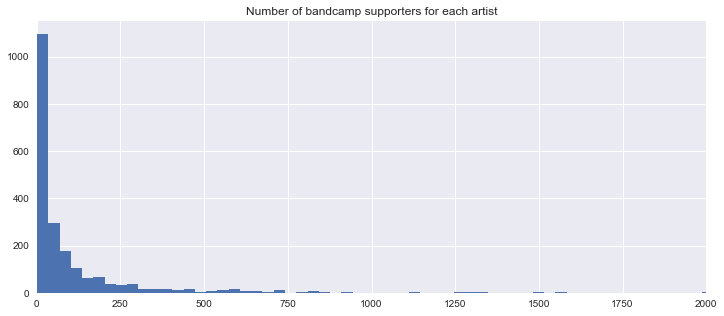

In [4]:
num_supporters = data.bc_num_supporters.values[data.bc_num_supporters.values != None]
num_supporters = num_supporters[~np.isnan(num_supporters)]
plt.figure(figsize=(12,5))
plt.hist(num_supporters,bins=300)
plt.title('Number of bandcamp supporters for each artist')
plt.xlim(0,2000)
print('Max number of sales is %.0f' % num_supporters.max())

(0, 100000)

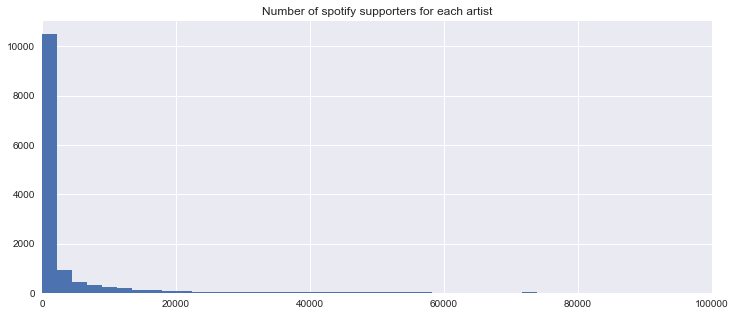

In [5]:
num_supporters_sp = data.sp_num_followers.values
plt.figure(figsize=(12,5))
plt.hist(num_supporters_sp,bins=5000)
plt.title('Number of spotify supporters for each artist')
plt.xlim(0,100000)

In [6]:
num_sales = data.sales_total_sales.values

Max number of sales is 293


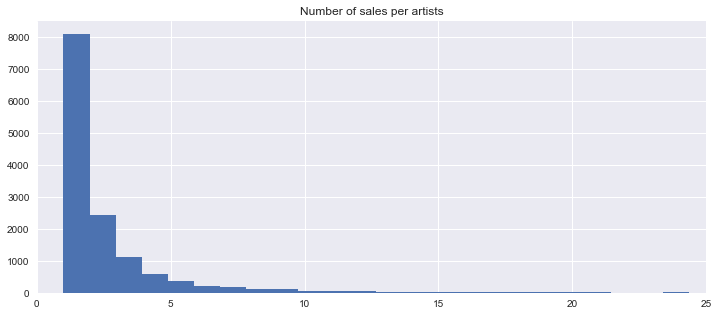

In [7]:
plt.figure(figsize=(12,5))
plt.hist(num_sales,bins=300)
plt.title('Number of sales per artists')
plt.xlim(0,25)
print('Max number of sales is %.0f' % num_sales.max())

In [8]:
avg_price = data.sales_total_revenue.values / data.sales_total_sales.values
bc_followers = data.bc_avg_supporters.values

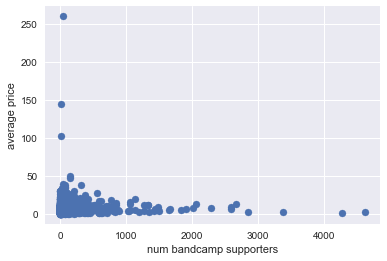

In [9]:
plt.scatter(bc_followers,avg_price)
plt.xlabel('num bandcamp supporters')
plt.ylabel('average price')
#plt.ylim(0,20)
#plt.xlim(20,5000)

In [4]:
all_genres = pd.read_csv('/Users/shayneufeld/Dropbox/insight/pricecamp/all_genres.csv',index_col=0)
genres = all_genres.genre.values

In [11]:
genre_counts = np.zeros(genres.shape[0])
for i,genre in tqdm(enumerate(genres)):
    for genre_str in data.sp_genres.values:
        if genre in genre_str:
            genre_counts[i] += 1

1643it [00:02, 653.72it/s]


In [12]:
all_genres['count'] = genre_counts

(0, 100)

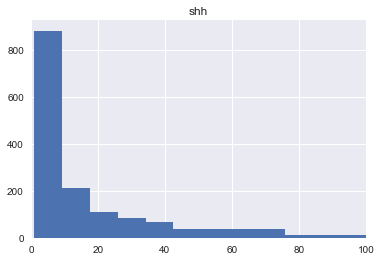

In [13]:
plt.hist(genre_counts,bins=1000)
plt.title('shh')
plt.xlim(0,100)

In [56]:
data_trimmed = data[data.sp_genres != 'none']

data_trimmed = data_trimmed[~data_trimmed.bc_num_albums.isnull()]

In [16]:
data_trimmed.shape

(1037, 24)

In [6]:
def get_artists_with_genre(artist_name,data,all_genres):
    df = data.copy()
    artist_genres_str = df[df.bc_artist == artist_name].sp_genres.values[0]
    
    artist_genres = artist_genres_str.replace('[','')
    artist_genres = artist_genres.replace(']','')
    artist_genres = artist_genres.split(sep=',')
    
    hits = []
    for genre in artist_genres:
        for i,genre_str in enumerate(data.sp_genres.values):
            if genre in genre_str:
                hits.append(i)
    
    results = df.iloc[hits].drop_duplicates()
    
    results = results[results.bc_artist != artist_name] #remove self from list
    
    return results

In [145]:
def get_features(artist_name,data,features): 
    d = data.loc[data.bc_artist == artist_name]
    x_test = d[features].values
    y_test = d.bc_avg_supporters.values
    #x_test = data.loc[data.bc_artist == artist_name,features].values
    #y_test = data.loc[data.bc_artist == artist_name,'bc_avg_supporters'].values
    
    return x_test,y_test

In [26]:
scores = []
y_predict = []
y_true = []
err2all = 0
err2genre = 0
err2model = 0
features = ['sp_popularity','sp_num_followers']
artists_modeled = []
i = 0 
err = np.zeros(670)
for artist_name in tqdm(data_trimmed.bc_artist.values):
    results = get_artists_with_genre(artist_name,data_trimmed,all_genres)
    x = results.loc[:,features].values
    y = results.bc_avg_supporters.values
    if x.shape[0] > 10:
        artists_modeled.append(artist_name)
        reg = linear_model.LinearRegression(normalize=True)
        reg.fit(x,y)
        scores.append(reg.score(x,y))
        
        [x_test,y_test] = get_features(artist_name,data_trimmed,features)
        #predict
        y_predict.append(reg.predict(x_test)[0])
        y_true.append(y_test)
        #sum of squared errors
        err2all += (y_true[-1] - data_trimmed.bc_avg_supporters.mean())**2
        err2genre += (y_true[-1] - results.bc_avg_supporters.mean())**2
        err2model += (y_predict[-1] - y_true[-1])**2
        err[i] = np.abs(y_predict[-1] - y_true[-1])
        i+=1

100%|██████████| 1037/1037 [00:10<00:00, 94.99it/s] 


In [20]:
print('Sum of squared errors wrt ALL ARTISTS: %.0f' % (err2all[0]))
print('Sum of squared errors wrt SIMILAR ARTISTS: %.0f' % (err2genre[0]))
print('Sum of squared errors wrt MODEL: %.0f' % (err2model[0]))

Sum of squared errors wrt ALL ARTISTS: 113312398
Sum of squared errors wrt SIMILAR ARTISTS: 98335931
Sum of squared errors wrt MODEL: 95526841


In [32]:
artists_modeled[23]

'Woodhawk'

(0, 25)

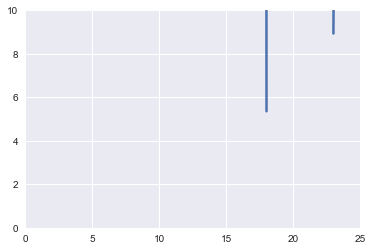

In [29]:
plt.plot(err)
plt.ylim(0,10)
plt.xlim(0,25)

In [37]:
rel_artists = get_artists_with_genre(artist_name,data_trimmed,all_genres)
x = rel_artists.loc[:,features].values
y = rel_artists.bc_avg_supporters.values
reg = linear_model.LinearRegression(normalize=True)
reg.fit(x,y)

[x_test,y_test] = get_features(artist_name,data,features)
y_predict = reg.predict(x_test)

In [124]:
features = ['sp_popularity','sp_num_followers']

In [ ]:
data_trimmed.sa

In [157]:
def ModelIt(fromUser  = 'Default', rel_artists = [],artist_name=[],data=data_trimmed,features=features):
    x = rel_artists.loc[:,features].values
    y = rel_artists.bc_avg_supporters.values
    reg = linear_model.LinearRegression(normalize=True)
    reg.fit(x,y)
    
    [x_test,y_test] = get_features(artist_name,data,features)
    
    y_predicts = []
    
    return [y_predict,y_test]

In [127]:
[x_test,y_test] = get_features(artist_name,data,features)

<bound method NDFrame.pop of                           bc_artist  bc_avg_supporters  bc_num_albums  \
0                         Whitebear         150.000000            1.0   
0              Algernon Cadwallader         223.000000            1.0   
0                          Joe King           2.000000            1.0   
0                        Falkenbach           8.000000            1.0   
0                          Oto Hiax          55.000000            2.0   
0                         Audra Mae           7.000000            1.0   
0                         Einherjer           3.000000            1.0   
0                       Timecop1983          12.000000            1.0   
0                          Eruption          89.000000            1.0   
0                       Boy Harsher          26.500000            2.0   
0                      NECRONOMIDOL         121.000000            1.0   
0                           Jay Som         696.000000            1.0   
0                     

In [186]:
artist_name = 'Waxahatchee'
y_predict,y_test = ModelIt(rel_artists = get_artists_with_genre(artist_name,data_trimmed,all_genres),artist_name=artist_name)

ValueError: too many values to unpack (expected 2)

In [185]:
y_predicts

[array([ 1864.09325826]),
 array([ 2045.67460741]),
 array([ 2227.25595656]),
 array([ 2408.83730571]),
 array([ 2590.41865487]),
 array([ 2772.00000402]),
 array([ 2953.58135317]),
 array([ 3135.16270232]),
 array([ 3316.74405147]),
 array([ 3498.32540062]),
 array([ 3679.90674977]),
 array([ 3861.48809892]),
 array([ 4043.06944808]),
 array([ 4224.65079723]),
 array([ 4406.23214638]),
 array([ 4587.81349553]),
 array([ 4769.39484468]),
 array([ 4950.97619383]),
 array([ 5132.55754298]),
 array([ 5314.13889214]),
 array([ 5495.72024129]),
 array([ 5677.30159044]),
 array([ 5858.88293959]),
 array([ 6040.46428874]),
 array([ 6222.04563789]),
 array([ 6403.62698704]),
 array([ 6585.20833619]),
 array([ 6766.78968535]),
 array([ 6948.3710345]),
 array([ 7129.95238365])]

In [119]:
y_test

array([ 86.])

In [57]:
data_trimmed['support_level'] = 'medium'
data_trimmed.loc[data_trimmed.bc_avg_supporters < 50,'support_level'] = 'low'
data_trimmed.loc[data_trimmed.bc_avg_supporters > 500,'support_level'] = 'high'

In [163]:
low.sales_avgprice.mean()

6.42721134896055

In [165]:
medium.sales_avgprice.mean()

8.085306868330397

In [166]:
high.sales_avgprice.mean()

7.6977296506939243

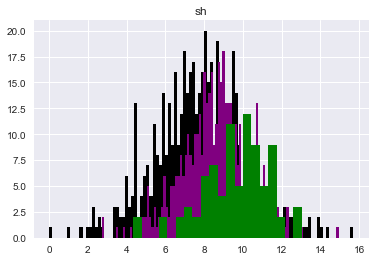

In [178]:
plt.hist(np.log(low.sp_num_followers),bins=100,color='black')
plt.hist(np.log(medium.sp_num_followers),bins=100,color='purple')
plt.hist(np.log(high.sp_num_followers),bins=20,color='green')
plt.title('sh')

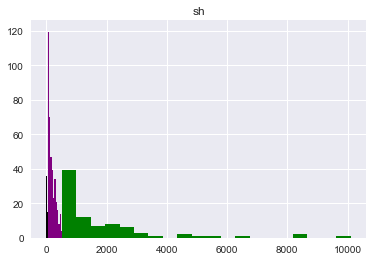

In [182]:
plt.hist(low.bc_num_supporters,bins=60,color='black')
plt.hist(medium.bc_num_supporters,bins=60,color='purple')
plt.hist(high.bc_num_supporters,bins=20,color='green')
plt.title('sh')

(0, 40)

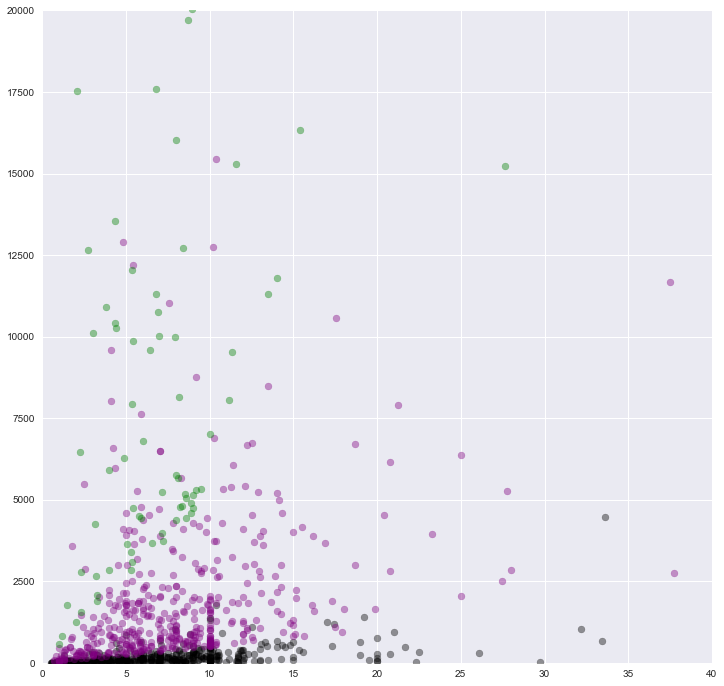

In [68]:
low = data_trimmed[data_trimmed.support_level == 'low']
medium = data_trimmed[data_trimmed.support_level == 'medium']
high = data_trimmed[data_trimmed.support_level == 'high']

plt.figure(figsize=(12,12))
plt.scatter(low.sales_avgprice,low.bc_num_supporters.values*low.sales_avgprice.values,
            color='black',label='low',alpha=0.4)
plt.scatter(medium.sales_avgprice,medium.bc_num_supporters.values*medium.sales_avgprice.values,
            color='purple',label='medium',alpha=0.4)
plt.scatter(high.sales_avgprice,high.bc_num_supporters.values*high.sales_avgprice.values,
            color='green',label='hight',alpha=0.4)

plt.ylim(0,20000)
plt.xlim(0,40)

In [72]:
rel_artists

,bc_artist,bc_avg_supporters,bc_num_albums,bc_num_supporters,sales_album_dl_avgprice,sales_album_dl_revenue,sales_album_dl_sales,sales_album_p_avgprice,sales_album_p_revenue,sales_album_p_sales,...,sales_total_sales,sales_track_dl_avgprice,sales_track_dl_revenue,sales_track_dl_sales,sp_artist,sp_genres,sp_num_followers,sp_popularity,sp_related_artists,support_level
0,Pearson Sound,17.400000,5.0,87.0,1.300000,1.30,1,9.120000,9.12,1,...,7,1.304000,6.52,5,Pearson Sound,"['bass music', 'dubstep', 'float house', 'flux...",5172,29,"['Pangaea', 'Untold', 'Ramadanman', 'Bok Bok',...",low
0,Roska,6.000000,1.0,6.0,2.991000,29.91,10,NaN,0.00,0,...,14,1.290000,5.16,4,Roska,"['bass music', 'future garage', 'uk funky']",1863,23,"['Bok Bok', 'Brackles', 'Mosca', 'Addison Groo...",low
0,Joy Orbison,101.000000,1.0,101.0,3.262500,13.05,4,NaN,0.00,0,...,10,1.583333,9.50,6,Joy Orbison,"['bass music', 'deep house', 'dubstep', 'futur...",20585,39,"['Sepalcure', 'Boddika', 'Pearson Sound', 'Fal...",medium
0,Four Tet,395.000000,1.0,395.0,6.363333,57.27,9,NaN,0.00,0,...,36,1.308846,34.03,26,Four Tet,"['alternative dance', 'bass music', 'big beat'...",174801,59,"['Burial', 'Mount Kimbie', 'Boards of Canada',...",medium
0,Fatima Al Qadiri,1.000000,1.0,1.0,NaN,0.00,0,NaN,0.00,0,...,1,1.750000,1.75,1,Fatima Al Qadiri,"['bass music', 'escape room', 'fluxwork', 'gra...",13011,32,"['Holy Other', 'Laurel Halo', 'Hype Williams',...",low
0,Nathan Fake,92.000000,1.0,92.0,7.150000,14.30,2,NaN,0.00,0,...,3,1.300000,1.30,1,Nathan Fake,"['acid house', 'bass music', 'chamber psych', ...",33342,44,"['Luke Abbott', 'James Holden', 'Pantha Du Pri...",medium
0,Randomer,47.000000,1.0,47.0,5.025000,50.25,10,NaN,0.00,0,...,25,2.000000,30.00,15,Randomer,"['bass music', 'float house', 'outsider house']",4701,32,"['Pangaea', 'Pearson Sound', 'Boddika', 'Ramad...",low
0,Floating Points,61.000000,1.0,61.0,8.200000,41.00,5,NaN,0.00,0,...,7,1.620000,3.24,2,Floating Points,"['alternative dance', 'bass music', 'chamber p...",68383,52,"['FaltyDL', 'Actress', 'Mount Kimbie', 'Mark P...",medium
0,Boxcutter,7.500000,2.0,15.0,4.358571,30.51,7,NaN,0.00,0,...,8,1.300000,1.30,1,Boxcutter,"['bass music', 'drill and bass', 'dubstep', 'w...",3213,19,"[""Vex'd"", 'Pinch', 'Ital Tek', 'Scuba', 'Marty...",low
0,Oneohtrix Point Never,85.000000,1.0,85.0,6.000000,6.00,1,7.250000,14.50,2,...,4,0.500000,0.50,1,Oneohtrix Point Never,"['ambient', 'bass music', 'chillwave', 'compos...",46238,47,"['James Ferraro', 'Tim Hecker', 'Emeralds', 'S...",medium


In [105]:
artist_name = 'Ratboys'
rel_artists = get_artists_with_genre(artist_name,data_trimmed,all_genres)

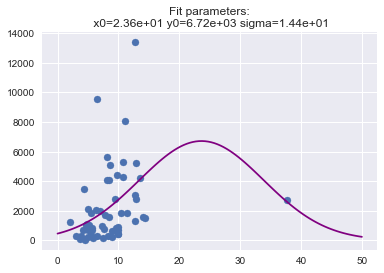

In [110]:
x0, sigma = 0,0

x = rel_artists.sales_avgprice
y = rel_artists.sales_avgprice*rel_artists.bc_avg_supporters

from scipy.optimize import curve_fit
# Function to be fitted

def gauss(x, x0, y0, sigma):
    p = [x0, y0, sigma]
    return p[1]* np.exp(-((x-p[0])/p[2])**2)

# Initialization parameters
p0 = [1., 1., 1.]
# Fit the data with the function
fit, tmp = curve_fit(gauss, x, y, p0=None)

# Plot the results
plt.title('Fit parameters:\n x0=%.2e y0=%.2e sigma=%.2e' % (fit[0], fit[1], fit[2]))
# Data
plt.scatter(x, y)
# Fitted function
x_fine = np.linspace(0, 50, 100)
plt.plot(x_fine, gauss(x_fine, fit[0], fit[1], fit[2]), 'purple')

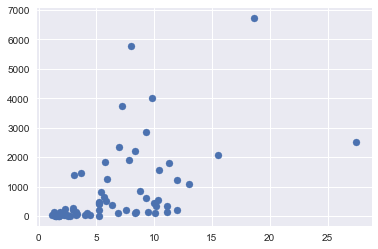

In [80]:
rel_artists = get_artists_with_genre(artist_name,data_trimmed,all_genres)
plt.scatter(rel_artists.sales_avgprice,rel_artists.sales_avgprice*rel_artists.bc_avg_supporters)

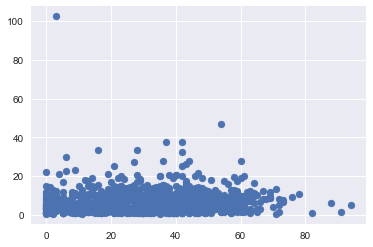

In [76]:
plt.scatter(data_trimmed.sp_popularity,data_trimmed.sales_avgprice)

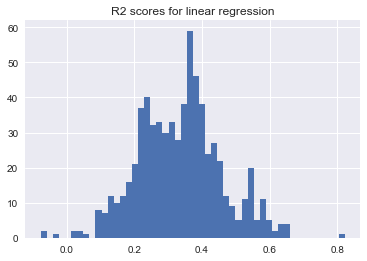

In [17]:
plt.hist(scores,bins=50)
plt.title('R2 scores for linear regression')

# Try kNN

In [11]:
scores = []
y_predict = []
y_true = []
y_predict_mean = []
features = ['sp_popularity','sp_num_followers']
count = 0
err2all = 0
err2genre = 0
err2model = 0

for artist_name in tqdm(data_trimmed.bc_artist.values):
    results = get_artists_with_genre(artist_name,data_trimmed,all_genres)
    x = results.loc[:,features].values
    y = results.bc_avg_supporters.values
    if x.shape[0] > 10:
        knn = neighbors.KNeighborsRegressor(n_neighbors=3,weights='uniform')
        knn.fit(x,y)
        y_true.append(data[data.bc_artist==artist_name].bc_avg_supporters.values[0])
        x_test,y_test = get_features(artist_name,data_trimmed,features)
        y_predict.append(knn.predict(x_test)[0])
        y_predict_mean.append(results.bc_avg_supporters.mean())
        y_true.append(y_test)
        scores.append(knn.score(x,y))
        neighbor_inds = knn.kneighbors(x_test,return_distance=False)[0]
        kneighbors = results.iloc[neighbor_inds]
        err2all += (y_true[-1] - data_trimmed.bc_avg_supporters.mean())**2
        err2genre += (y_true[-1] - y_predict_mean[-1])**2
        err2model += (y_predict[-1] - y_true[-1])**2
    else:
        count+=1

100%|██████████| 1037/1037 [00:13<00:00, 79.76it/s]


238.33333333333334

In [14]:
print('Sum of squared errors wrt ALL ARTISTS: %.0f' % (err2all[0]))
print('Sum of squared errors wrt SIMILAR ARTISTS: %.0f' % (err2genre[0]))
print('Sum of squared errors wrt MODEL: %.0f' % (err2model[0]))

Sum of squared errors wrt ALL ARTISTS: 113312398
Sum of squared errors wrt SIMILAR ARTISTS: 98335931
Sum of squared errors wrt MODEL: 119651523


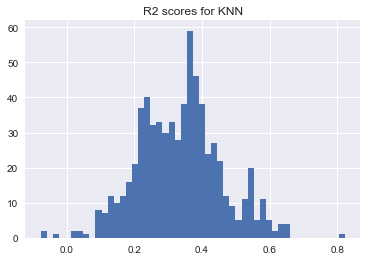

In [15]:
plt.hist(scores,bins=50)
plt.title('R2 scores for KNN')

(0, 2000)

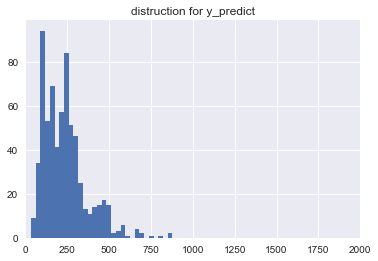

In [16]:
plt.hist(np.asarray(y_predict_mean),bins=30)
plt.title('distruction for y_predict')
plt.xlim(0,2000)

(0, 2000)

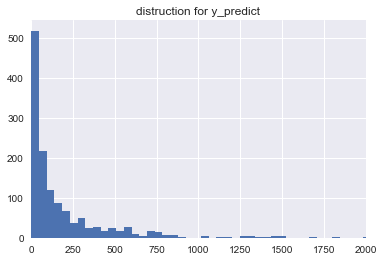

In [45]:
plt.hist(np.asarray(y_true),bins=100)
plt.title('distruction for y_predict')
plt.xlim(0,2000)

## try decision tree on the sparse matrix

In [49]:
import scipy as sc

In [50]:
adj_sparse = sc.sparse.load_npz('/Users/shayneufeld/Dropbox/insight/pricecamp/adj_sparse.npz')

In [53]:
from sklearn.tree import DecisionTreeRegressor

In [54]:
tree = DecisionTreeRegressor()
tree.fit()

In [ ]:
data_trimmed